# [6주차] Basic Deep Learning(2)

---
# Lab 10-1) Relu

은닉층에서 주로 사용되는 활성화 함수

### Relu를 은닉층에서 많이 사용하는 이유
1. 기울기 소실 (Vanishing Gradient) 문제가 발생하지 않는다. -> 시그모이드에서 발생
2. 기존 활성화 함수에 비해 속도가 매우 빠르다.

### Relu의 한계
1. 렐루의 그래프를 보면 음수 값도 전부 0으로 반환하다 보니, 가중치 합이 음수가 되는 순간 가중치 업데이트가 안되는 현상이 발생한다
2. 시그모이드 함수처럼 가중치 업데이트 시 지그재그 현상이 발생한다.
3. 렐루의 미분은 0 초과시 1, 0은 0으로 끊기기 때문에 0에서 미분이 불가능하다.

## Load mnist

In [4]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
from time import time
import os

In [3]:
tf.enable_eager_execution()

AttributeError: module 'tensorflow' has no attribute 'enable_eager_execution'

In [5]:
def load_mnist() :
    (train_data, train_labels), (test_data, test_labels) = mnist.load_data()
    train_data = np.expand_dims(train_data, axis=-1) # [N, 28, 28] -> [N, 28, 28, 1]
    test_data = np.expand_dims(test_data, axis=-1) # [N, 28, 28] -> [N, 28, 28, 1]

    train_data, test_data = normalize(train_data, test_data)

    train_labels = to_categorical(train_labels, 10) # [N,] -> [N, 10]
    test_labels = to_categorical(test_labels, 10) # [N,] -> [N, 10]

    return train_data, train_labels, test_data, test_labels

def normalize(train_data, test_data):
    train_data = train_data.astype(np.float32) / 255.0
    test_data = test_data.astype(np.float32) / 255.0

    return train_data, test_data

## Create Network

In [ ]:
def flatten() :
    return tf.keras.layers.Flatten()

def dense(label_dim, weight_init) :
    return tf.keras.layers.Dense(units=label_dim, use_bias=True, kernel_initializer=weight_init)

def sigmoid() :
    return tf.keras.layers.Activation(tf.keras.activations.sigmoid)

## Class ver
class create_model_class(tf.keras.Model):
    def __init__(self, label_dim):
        super(create_model_class, self).__init__()
        weight_init = tf.keras.initializers.RandomNormal()

        self.model = tf.keras.Sequential()
        self.model.add(flatten()) # [N,28,28,1] -> [N,784]

        for i in range(2):
            self.model.add(dense(256, weight_init))
            self.model.add(sigmoid())

        self.model.add(dense(label_dim, weight_init))

    def call(self, x, training=None, mask=None):
        x = self.model(x)

        return x
    
    
## Func ver
def create_model_function(label_dim) :
    weight_init = tf.keras.initializers.RabndomNormal()

    model = tf.keras.Sequential()
    model.add(flatten())

    for i in range(2) :
        model.add(dense(256, weight_init))
        model.add(sigmoid())

    model.add(dense(label_dim, weight_init))

    return model

## Define loss

In [6]:
def loss_fn(model, images, labels):
    logits = model(images, training=True)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=labels))
    return loss

def accuracy_fn(model, images, labels):
    logits = model(images, training=False)
    prediction = tf.equal(tf.argmax(logits, -1), tf.argmax(labels, -1))
    accuracy = tf.reduce_mean(tf.cast(prediction, tf.float32))
    return accuracy

def grad(model, images, labels):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, images, labels)
    return tape.gradient(loss, model.variables)

## Experiments (parameters && models)

""" dataset """
train_x, train_y, test_x, test_y = load_mnist()

""" parameters """
learning_rate = 0.001
batch_size = 128

training_epochs = 1
training_iterations = len(train_x) // batch_size

label_dim = 10

train_flag = True

""" Graph Input using Dataset API """
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y)).\
    shuffle(buffer_size=100000).\
    prefetch(buffer_size=batch_size).\
    batch(batch_size).\
    repeat()

test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y)).\
    shuffle(buffer_size=100000).\
    prefetch(buffer_size=len(test_x)).\
    batch(len(test_x)).\
    repeat()


""" Dataset Iterator """
train_iterator = train_dataset.make_one_shot_iterator()
test_iterator = test_dataset.make_one_shot_iterator()

""" Model """
network = create_model(label_dim)

""" Training """
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

---
# Lab 10-2) Weight Initialization

가중치 초기화만으로 성능을 높게 향상시킬 수 있다.

## Xavier Initialization
- global minima가 아닌 local minima, 혹은 saddle point에 수렴할 위험이 있다.
- Weight 초기화는 네트워크가 어느 지점에서 출발할지 설정을 해주는 것이고, Xavier도 이를 위한 방법이다.
*평균: 0, 분산: 2/channel_in + channel_out

## He Initialization
- Relu에 특화된 초기화 방법
*평균: 0, 분산: 4/channel_in + channel_out

---
# Lab 10-3) Dropout

## Dropout을 사용하는 이유
- 오버피팅을 해결하기 위한 방법 
- hidden layer 중 일부 유닛이 동작하지 않게 하여 오버피팅을 막는다.
- 정규화 방식 중 하나이다.

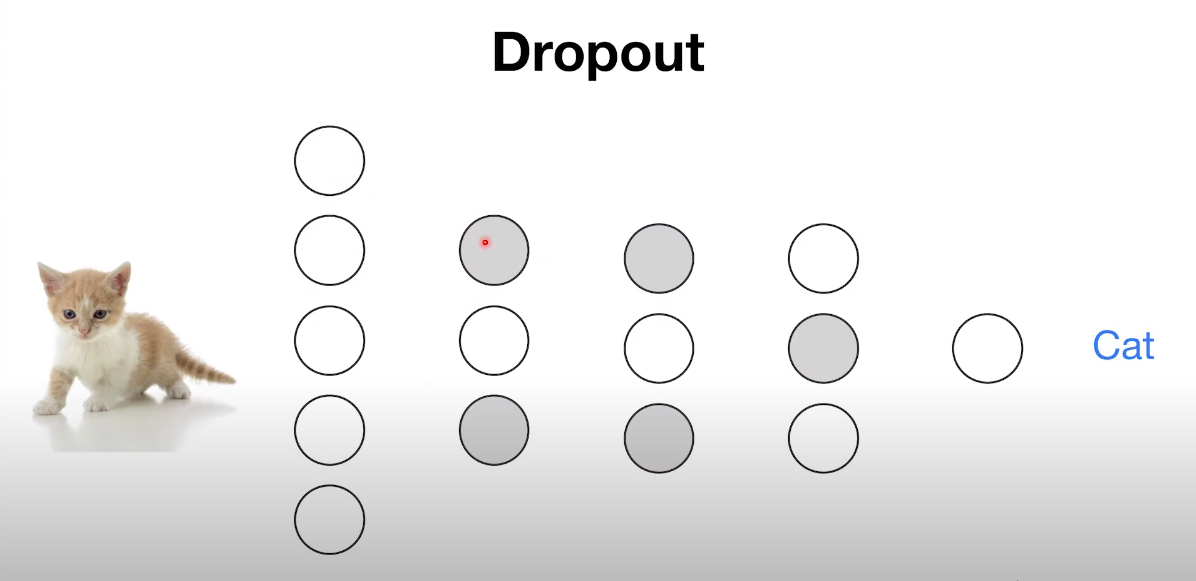

## Create network

In [21]:
def flatten() :
    return tf.keras.layers.Flatten()

def dense(label_dim, weight_init) :
    return tf.keras.layers.Dense(units=label_dim, use_bias=True, kernel_initializer=weight_init)

def relu():
    return tf.keras.layers.Activation(tf.keras.activations.relu)

def dropout(rate):
    return tf.keras.layers.Dropout(rate)

class create_model(tf.keras.Model):
    def __init__(self, label_dim):
        super(create_model, self).__init__()
        
        weight_init = tf.keras.initializers.glorot_uniform()
        self.model = tf.keras.Sequential()
        self.model.add(flatten()) # [N,28,28,1] -> [N,784]

        for i in range(2):
            self.model.add(dense(256, weight_init))
            self.model.add(relu())
            ## 이부분!!
            self.model.add(dropout(rate=0.5))

        self.model.add(dense(label_dim, weight_init))

    def call(self, x, training=None, mask=None):
        x = self.model(x)

        return x 

## Define loss

In [ ]:
def loss_fn(model, images, labels):
    logits = model(images, training=True) # True: dropout 사용
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=labels))
    return loss

def accuracy_fn(model, images, labels):
    logits = model(images, training=False) # False: dropout 사용x
    prediction = tf.equal(tf.argmax(logits, -1), tf.argmax(labels, -1))
    accuracy = tf.reduce_mean(tf.cast(prediction, tf.float32))
    return accuracy

def grad(model, images, labels):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, images, labels)
    return tape.gradient(loss, model.variables)

---
# Lab 10-4) Batch Normalization

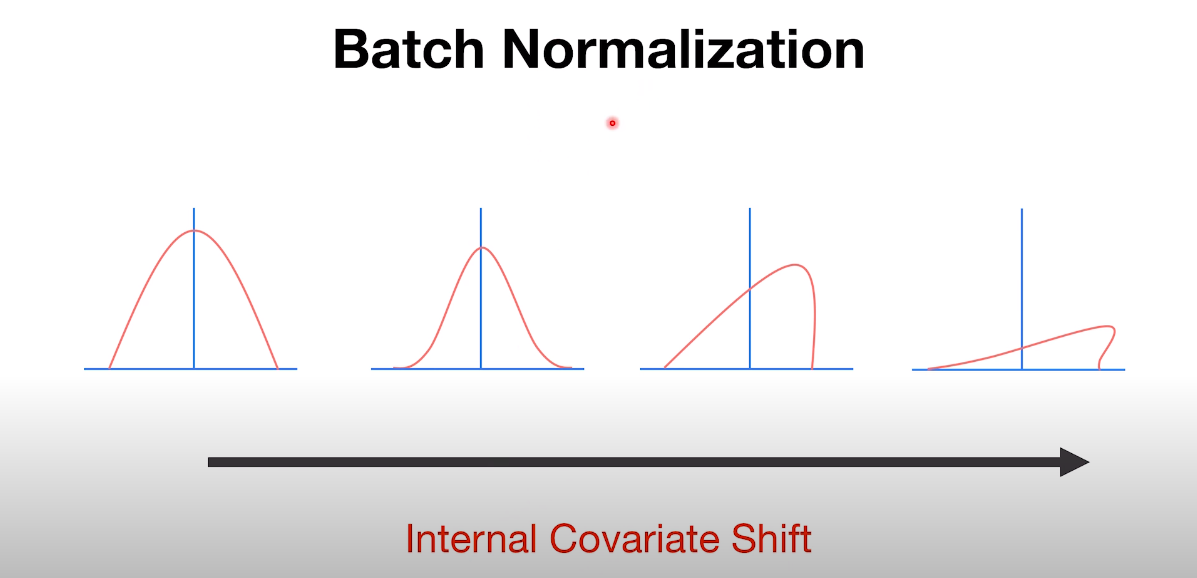

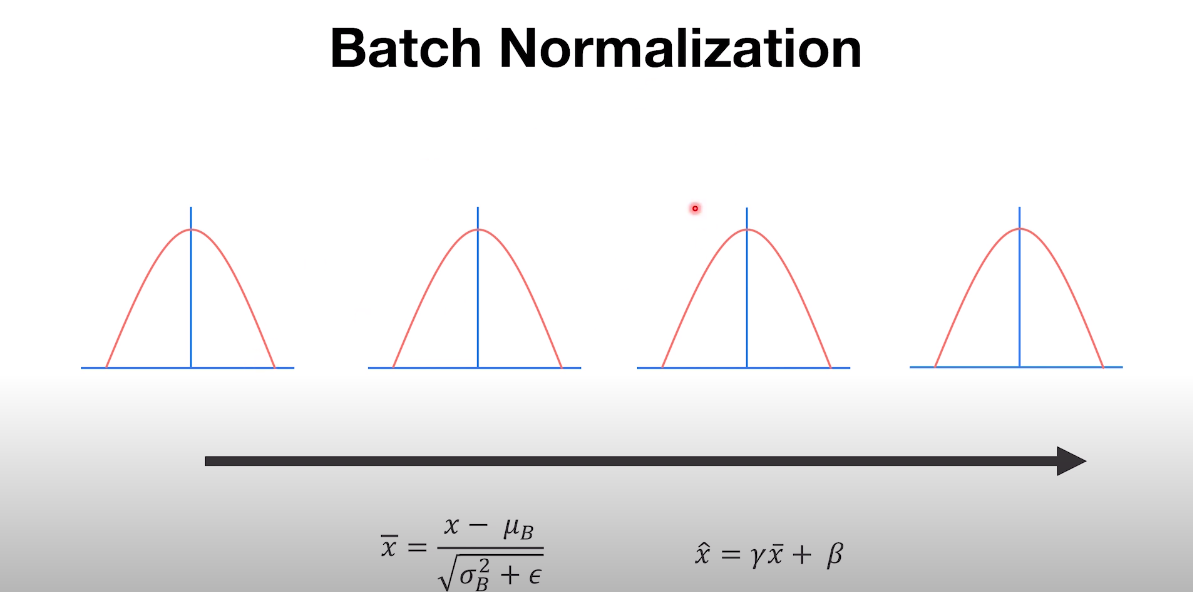

## Create network

In [23]:
def flatten() :
    return tf.keras.layers.Flatten()

def dense(label_dim, weight_init) :
    return tf.keras.layers.Dense(units=label_dim, use_bias=True, kernel_initializer=weight_init)

def relu():
    return tf.keras.layers.Activation(tf.keras.activations.relu)

def batch_norm():
    return tf.keras.layers.BatchNormalization()

class create_model(tf.keras.Model):
    def __init__(self, label_dim):
        super(create_model, self).__init__()
        
        weight_init = tf.keras.initializers.glorot_uniform()
        self.model = tf.keras.Sequential()
        self.model.add(flatten()) # [N,28,28,1] -> [N,784]

        for i in range(2):
            # 일반적으로 layer -> norm -> activation 순으로 작성
            self.model.add(dense(256, weight_init))
            ## 바뀐 부분
            self.model.add(batch_norm())
            self.model.add(relu())

        self.model.add(dense(label_dim, weight_init))

    def call(self, x, training=None, mask=None):
        x = self.model(x)

        return x 